# Fracture Classification and Localization Pipeline using ProtoViT and YOLOv8

This notebook implements a two-stage deep learning pipeline:
1. **Classification Stage (ProtoViT):** A ViT-based prototype network determines if an X-ray has a fracture.
2. **Detection Stage (YOLOv8):** If a fracture is found, the image is passed to a YOLOv8 object detector to localize the fracture.

We use the **FracAtlas** dataset, annotated in COCO format, containing both fractured and non-fractured X-ray images.


## 🔧 Environment Setup

We install the necessary packages and authenticate with Kaggle to download the dataset.


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"runananya","key":"d6c75433d05cc3f56e349ddb468c6133"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install -q kaggle

In [ ]:
!kaggle datasets list

ref                                                         title                                                  size  lastUpdated                 downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  -----------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
adilshamim8/student-depression-dataset                      Student Depression Dataset                           467020  2025-03-13 03:12:30.423000          15933        251  1.0              
atharvasoundankar/fashion-retail-sales                      🛍️ Fashion Retail Sales Dataset                       31656  2025-04-01 05:05:48.020000           1592         28  1.0              
zahidmughal2343/amazon-sales-2025                           Amazon Sales 2025                                      3617  2025-04-03 22:08:13.607000           2848         43  1.0              
adilshamim8/math-students          

## 📂 Dataset Download & Preprocessing

We download the FracAtlas dataset from Kaggle, unzip it, and read its COCO-style annotations.
The dataset is then preprocessed and split into `fractured` and `non-fractured` categories.


In [ ]:
!pip install transformers datasets torch torchvision kaggle
!kaggle datasets download mahmudulhasantasin/fracatlas-original-dataset

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!unzip fracatlas-original-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: FracAtlas/Annotations/YOLO/IMG0003207.txt  
  inflating: FracAtlas/Annotations/YOLO/IMG0003208.txt  
  inflating: FracAtlas/Annotations/YOLO/IMG0003209.txt  
  inflating: FracAtlas/Annotations/YOLO/IMG0003210.txt  
  inflating: FracAtlas/Annotations/YOLO/IMG0003211.txt  
  inflating: FracAtlas/Annotations/YOLO/IMG0003212.txt  
  inflating: FracAtlas/Annotations/YOLO/IMG0003213.txt  
  inflating: FracAtlas/Annotations/YOLO/IMG0003214.txt  
  inflating: FracAtlas/Annotations/YOLO/IMG0003215.txt  
  inflating: FracAtlas/Annotations/YOLO/IMG0003216.txt  
  inflating: FracAtlas/Annotations/YOLO/IMG0003217.txt  
  inflating: FracAtlas/Annotations/YOLO/IMG0003218.txt  
  inflating: FracAtlas/Annotations/YOLO/IMG0003219.txt  
  inflating: FracAtlas/Annotations/YOLO/IMG0003220.txt  
  inflating: FracAtlas/Annotations/YOLO/IMG0003221.txt  
  inflating: FracAtlas/Annotations/YOLO/IMG0003222.txt  
  inflating: FracAtlas/Annotations/YO

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.8/974.8 kB 37.6 MB/s eta 0:00:00


In [ ]:
import os
import json
import random


COCO_JSON = "/content/FracAtlas/Annotations/COCO JSON/COCO_fracture_masks.json"
IMAGES_DIR = "/content/FracAtlas/images/Fractured"
OUTPUT_DIR = "yolo_labels"

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load COCO data
with open(COCO_JSON, "r") as f:
    coco_data = json.load(f)

images_info = {img["id"]: img for img in coco_data["images"]}
annotations = coco_data["annotations"]
categories_info = coco_data.get("categories", [])


cat_ids = sorted(list({cat["id"] for cat in categories_info}))
catid2yolo = {cat_id: idx for idx, cat_id in enumerate(cat_ids)}

def coco_to_yolo_bbox(bbox, w, h):
    """
    Convert [x_min, y_min, width, height] in absolute float
    to [x_center, y_center, width, height] in relative coords.
    """
    x_min, y_min, bw, bh = bbox
    x_center = (x_min + bw / 2) / w
    y_center = (y_min + bh / 2) / h
    bw_rel = bw / w
    bh_rel = bh / h
    return (x_center, y_center, bw_rel, bh_rel)

# Process each annotation
for ann in annotations:
    img_id = ann["image_id"]
    cat_id = ann["category_id"]
    bbox = ann["bbox"]

    # Skip if image not found
    if img_id not in images_info:
        continue

    # Get image info
    img_info = images_info[img_id]
    img_w, img_h = img_info["width"], img_info["height"]
    # YOLO class index
    yolo_class_id = catid2yolo[cat_id]

    # Convert bbox
    x_center, y_center, bw, bh = coco_to_yolo_bbox(bbox, img_w, img_h)

    # Prepare line
    label_str = f"{yolo_class_id} {x_center:.6f} {y_center:.6f} {bw:.6f} {bh:.6f}\n"

    # Derive output file name from image file_name
    base_name = os.path.splitext(img_info["file_name"])[0]
    out_path = os.path.join(OUTPUT_DIR, base_name + ".txt")

    # Append to file (so multiple bboxes per image go in the same file)
    with open(out_path, "a") as f_out:
        f_out.write(label_str)

print(f"Conversion complete. YOLO labels saved in: {OUTPUT_DIR}")

# ============ Step 2: Spot check / verify some labels ============

# We'll just read a random .txt file from OUTPUT_DIR and print
label_files = [f for f in os.listdir(OUTPUT_DIR) if f.endswith(".txt")]
if label_files:
    sample_file = random.choice(label_files)
    print(f"\nRandom spot check for file: {sample_file}")
    with open(os.path.join(OUTPUT_DIR, sample_file), "r") as f_in:
        lines = f_in.readlines()
    print("Contents:")
    for line in lines:
        print(line.strip())


Conversion complete. YOLO labels saved in: yolo_labels

Random spot check for file: IMG0002287.txt
Contents:
0 0.252953 0.462871 0.076323 0.056106
0 0.805294 0.466997 0.092392 0.057756


In [ ]:
import os
import random
import shutil

IMAGES_DIR = "/content/FracAtlas/images/Fractured"
LABELS_DIR = "/content/yolo_labels"

OUTPUT_DIR = "dataset"  # we'll create dataset/images/train, dataset/images/val, dataset/labels/train, dataset/labels/val
TRAIN_RATIO = 0.8       # 80% for training, 20% for validation

# Create the subfolders
os.makedirs(os.path.join(OUTPUT_DIR, "images/train"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "images/val"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "labels/train"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "labels/val"), exist_ok=True)

# List all images
all_images = [f for f in os.listdir(IMAGES_DIR)
              if f.lower().endswith((".jpg", ".png", ".jpeg", ".bmp"))]

random.shuffle(all_images)

# Calculate split index
train_count = int(len(all_images) * TRAIN_RATIO)
train_images = all_images[:train_count]
val_images = all_images[train_count:]

def move_files(image_list, subset_name):
    for img_file in image_list:
        # Source image path
        src_img_path = os.path.join(IMAGES_DIR, img_file)
        # Destination image path
        dst_img_path = os.path.join(OUTPUT_DIR, f"images/{subset_name}", img_file)

        # Move (or copy) the image
        shutil.copy2(src_img_path, dst_img_path)

        # Now handle the label file
        base_name = os.path.splitext(img_file)[0]
        label_file = base_name + ".txt"
        src_label_path = os.path.join(LABELS_DIR, label_file)
        dst_label_path = os.path.join(OUTPUT_DIR, f"labels/{subset_name}", label_file)

        # If a label file exists, copy it
        if os.path.exists(src_label_path):
            shutil.copy2(src_label_path, dst_label_path)

# Move/copy images to train folder
move_files(train_images, "train")

# Move/copy images to val folder
move_files(val_images, "val")

print("Dataset split completed!")
print(f"Training images: {len(train_images)}")
print(f"Validation images: {len(val_images)}")

Dataset split completed!
Training images: 573
Validation images: 144


In [ ]:


%%writefile datafrac_v8.yaml
path: '/content/dataset'
train: '/content/dataset/images/train'
val: '/content/dataset/images/val'
#class names

names :
  0: fracture

Writing datafrac_v8.yaml


In [ ]:
EPOCHS = 80
BATCH = 8
IMG_SIZE=1280

In [ ]:
!yolo \
task=detect \
mode=train \
model=yolov8m.pt \
imgsz=640 \
data=datafrac_v8.yaml \
epochs=50 \
batch=16 \
name=yolov8m_50e






Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
100% 49.7M/49.7M [00:00<00:00, 339MB/s]
Ultralytics 8.3.109 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=datafrac_v8.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8m_50e, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None,

In [ ]:
!cp runs/detect/yolov8m_50e/weights/best.pt /content/drive/MyDrive/yolov8m_50e_best.pt


In [ ]:
save_dir="/content/drive/MyDrive/Colab_Notebooks/Trained_Models"

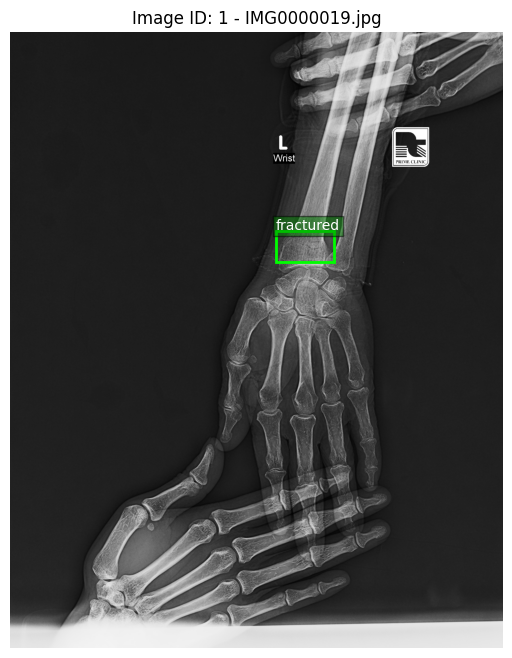

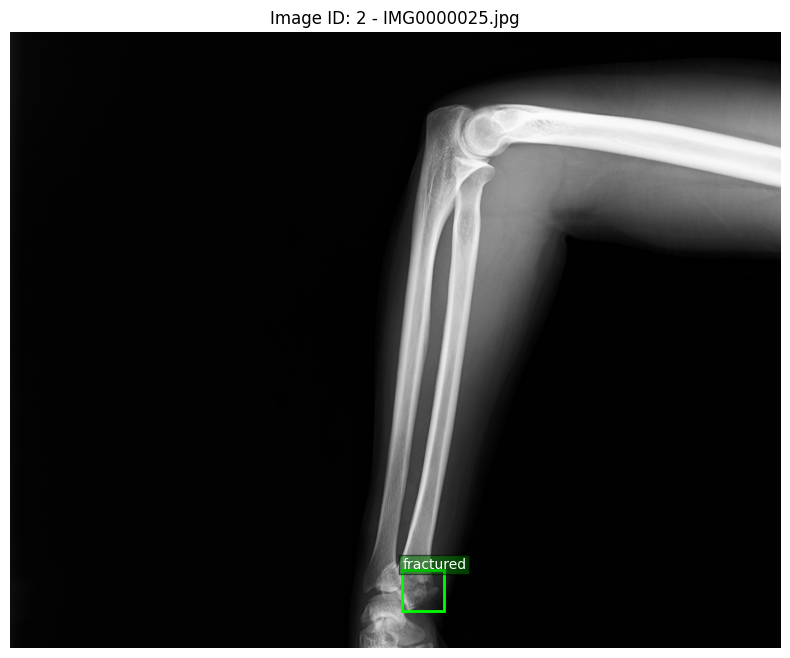

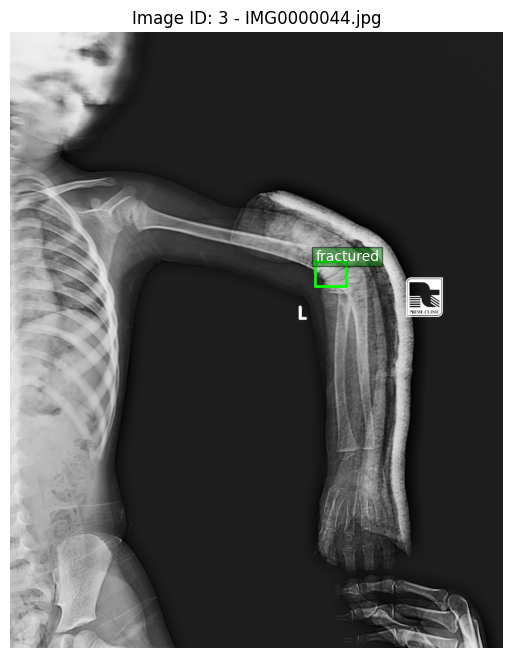

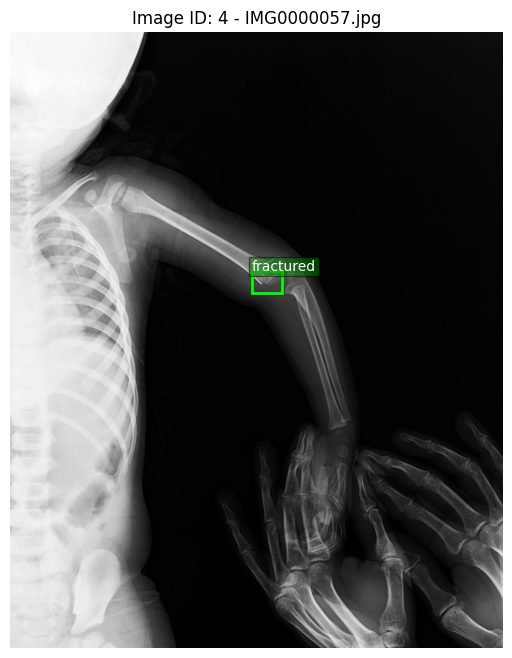

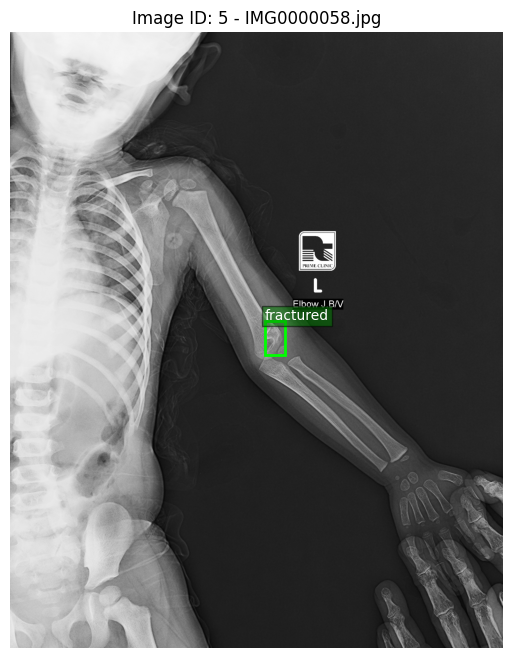

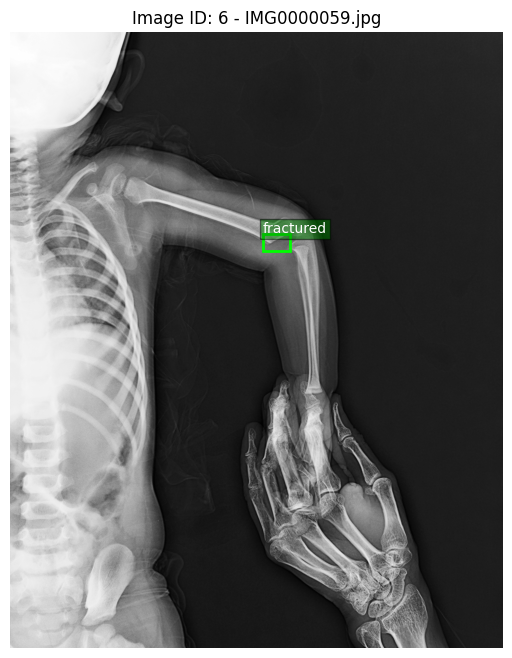

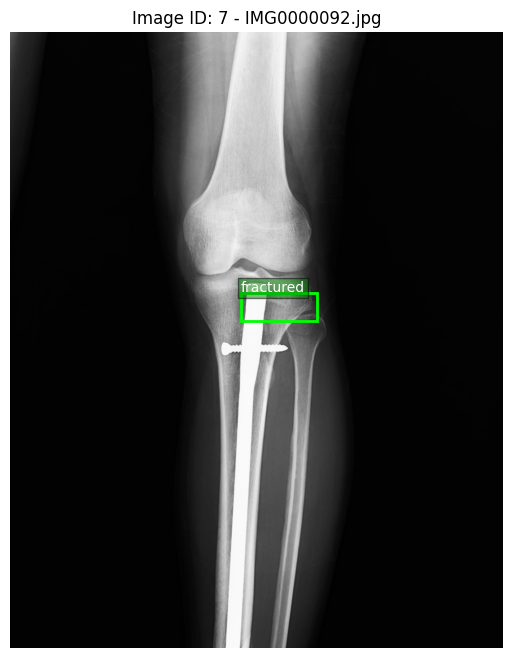

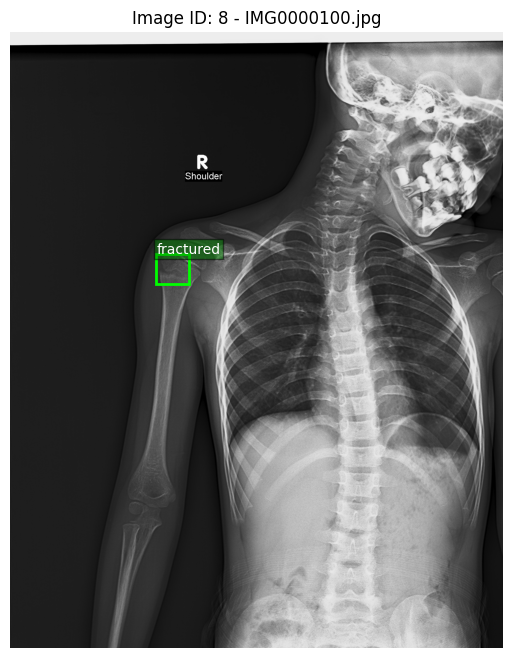

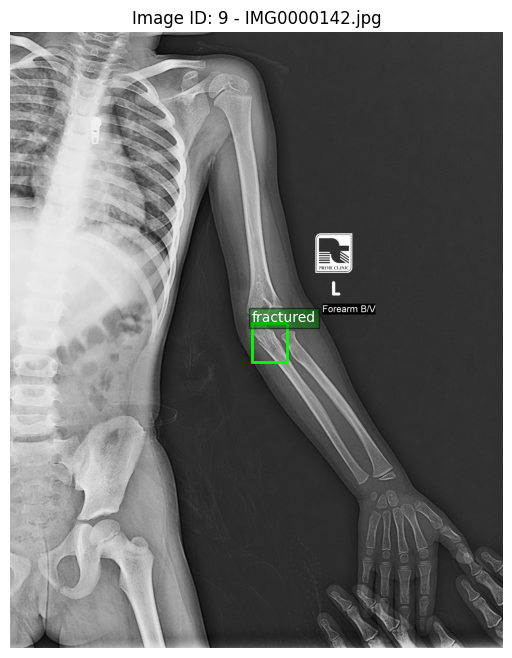

In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

# ---------------------------------------------------------------------
# 1. Set Paths
# ---------------------------------------------------------------------
file_path = "/content/FracAtlas/Annotations/COCO JSON/COCO_fracture_masks.json"
images_folder = "/content/FracAtlas/images/Fractured"

# ---------------------------------------------------------------------
# 2. Load COCO Data
# ---------------------------------------------------------------------
with open(file_path, "r") as file:
    coco_data = json.load(file)

images_df = pd.DataFrame(coco_data.get("images", []))
annotations_df = pd.DataFrame(coco_data.get("annotations", []))
categories_df = pd.DataFrame(coco_data.get("categories", []))


cat_id_to_name = dict(zip(categories_df["id"], categories_df["name"]))


def show_annotated_images(images_df, annotations_df, cat_id_to_name, images_folder, num_images=9):


    for idx in range(min(num_images, len(images_df))):
        image_row = images_df.iloc[idx]
        img_id = image_row["id"]
        filename = image_row["file_name"]
        img_path = os.path.join(images_folder, filename)


        image = cv2.imread(img_path)
        if image is None:
            print(f"Warning: Could not load image: {img_path}")
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


        image_annotations = annotations_df[annotations_df["image_id"] == img_id]


        fig, ax = plt.subplots(figsize=(10, 8))
        ax.imshow(image)


        for _, ann_row in image_annotations.iterrows():
            x, y, w, h = ann_row["bbox"]
            rect = patches.Rectangle(
                (x, y), w, h, linewidth=2, edgecolor='lime', facecolor='none'
            )
            ax.add_patch(rect)


            cat_id = ann_row["category_id"]
            cat_name = cat_id_to_name.get(cat_id, str(cat_id))
            ax.text(
                x, y - 5,
                cat_name,
                fontsize=10, color='white',
                bbox=dict(facecolor='green', alpha=0.5, pad=2)
            )

        ax.set_title(f"Image ID: {img_id} - {filename}")
        plt.axis('off')
        plt.show()

show_annotated_images(images_df, annotations_df, cat_id_to_name, images_folder, num_images=9)



image 1/1 /content/FracAtlas/images/Fractured/IMG0000059.jpg: 640x512 1 fracture, 40.4ms
Speed: 3.1ms preprocess, 40.4ms inference, 171.2ms postprocess per image at shape (1, 3, 640, 512)


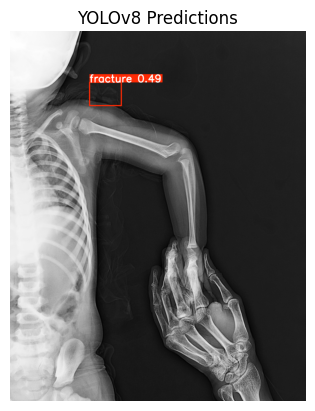

In [ ]:
import matplotlib.pyplot as plt
from ultralytics import YOLO


model_path = "/content/drive/MyDrive/yolov8m_50e_best.pt"
image_path = "/content/FracAtlas/images/Fractured/IMG0000059.jpg"

model = YOLO(model_path)


results = model(image_path, conf=0.2)


results_plotted = results[0].plot()

plt.imshow(results_plotted)
plt.axis('off')
plt.title("YOLOv8 Predictions")
plt.show()


In [ ]:
import os
import json
import pandas as pd
from ultralytics import YOLO
import cv2

# ---------------------------------------------------------------------
# 1. Set Paths
# ---------------------------------------------------------------------
file_path = "/content/FracAtlas/Annotations/COCO JSON/COCO_fracture_masks.json"
images_folder = "/content/FracAtlas/images/Fractured"
model_path = "/content/drive/MyDrive/yolov8m_50e_best.pt"

# ---------------------------------------------------------------------
# 2. Load COCO Data
# ---------------------------------------------------------------------
with open(file_path, "r") as file:
    coco_data = json.load(file)

images_df = pd.DataFrame(coco_data.get("images", []))
annotations_df = pd.DataFrame(coco_data.get("annotations", []))
categories_df = pd.DataFrame(coco_data.get("categories", []))

cat_id_to_name = dict(zip(categories_df["id"], categories_df["name"]))

# Load the YOLO model
model = YOLO(model_path)

# ---------------------------------------------------------------------
# 3. Helper Function: Calculate IoU
# ---------------------------------------------------------------------
def calculate_iou(boxA, boxB):
    """
    Calculate Intersection over Union (IoU) between two boxes.
    boxA, boxB: [x1, y1, x2, y2]
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # Compute the areas of both boxes
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # Compute IoU
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

# ---------------------------------------------------------------------
# 4. Function: Calculate IoU for All Images
# ---------------------------------------------------------------------
def calculate_iou_for_all_images(
    images_df, annotations_df, cat_id_to_name, images_folder, model
):
    iou_results = []  # To store IoU results

    for _, image_row in images_df.iterrows():
        img_id = image_row["id"]
        filename = image_row["file_name"]
        img_path = os.path.join(images_folder, filename)

        # Load image
        image = cv2.imread(img_path)
        if image is None:
            print(f"Warning: Could not load image: {img_path}")
            continue

        # Get ground truth annotations for the image
        image_annotations = annotations_df[annotations_df["image_id"] == img_id]

        # Get predictions from the YOLO model
        results = model(img_path, conf=0.3)
        predictions = results[0].boxes  # Get the Boxes object

        # Process predictions and ground truth
        if predictions is not None and len(predictions) > 0:
            for pred in predictions:
                x1, y1, x2, y2 = pred.xyxy[0].cpu().numpy()  # Bounding box coordinates
                conf = pred.conf[0].cpu().item()            # Confidence score
                cls = pred.cls[0].cpu().item()              # Class ID

                pred_box = [x1, y1, x2, y2]
                pred_class_name = model.names[int(cls)]

                # Compare with all ground truth boxes
                for _, ann_row in image_annotations.iterrows():
                    gt_x, gt_y, gt_w, gt_h = ann_row["bbox"]
                    gt_box = [gt_x, gt_y, gt_x + gt_w, gt_y + gt_h]
                    gt_class_name = cat_id_to_name.get(ann_row["category_id"], "Unknown")

                    # Calculate IoU
                    iou = calculate_iou(gt_box, pred_box)

                    # Append result
                    iou_results.append({
                        "image_id": img_id,
                        "image_name": filename,
                        "gt_box": gt_box,
                        "gt_class": gt_class_name,
                        "pred_box": pred_box,
                        "pred_class": pred_class_name,
                        "confidence": conf,
                        "iou": iou
                    })

    # Convert results to DataFrame
    iou_df = pd.DataFrame(iou_results)
    return iou_df

# ---------------------------------------------------------------------
# 5. Run the Function and Save Results
# ---------------------------------------------------------------------
iou_df = calculate_iou_for_all_images(
    images_df, annotations_df, cat_id_to_name, images_folder, model
)

# Save results to a CSV file
output_csv_path = "/content/iou_results.csv"
iou_df.to_csv(output_csv_path, index=False)
print(f"IoU results saved to {output_csv_path}")


# Display the IoU DataFrame
print(iou_df)






image 1/1 /content/FracAtlas/images/Fractured/IMG0000019.jpg: 640x512 1 fracture, 28.9ms
Speed: 3.1ms preprocess, 28.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /content/FracAtlas/images/Fractured/IMG0000025.jpg: 512x640 2 fractures, 41.7ms
Speed: 3.0ms preprocess, 41.7ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /content/FracAtlas/images/Fractured/IMG0000044.jpg: 640x512 (no detections), 29.2ms
Speed: 3.0ms preprocess, 29.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /content/FracAtlas/images/Fractured/IMG0000057.jpg: 640x512 2 fractures, 28.2ms
Speed: 3.0ms preprocess, 28.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /content/FracAtlas/images/Fractured/IMG0000058.jpg: 640x512 1 fracture, 28.2ms
Speed: 3.0ms preprocess, 28.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /content/FracAtlas/images/Fractured/IMG0000059.

In [ ]:
mean_iou = iou_df["iou"].mean()
print(f"Mean IoU across all images: {mean_iou:.4f}")

Mean IoU across all images: 0.4633



image 1/1 /content/FracAtlas/images/Fractured/IMG0000019.jpg: 640x512 1 fracture, 29.4ms
Speed: 4.2ms preprocess, 29.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


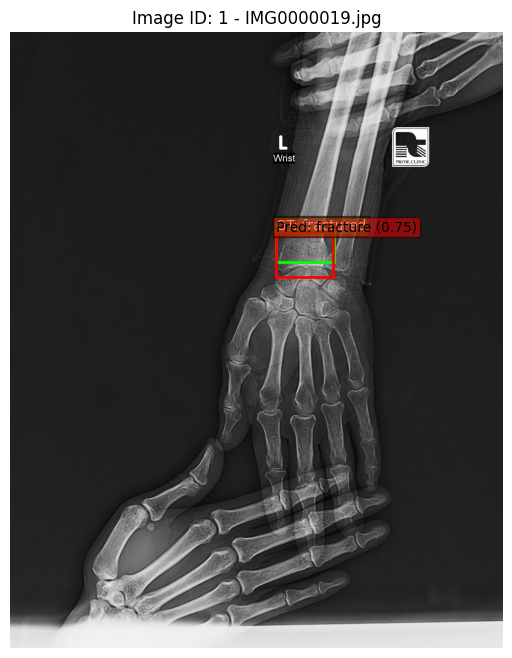


image 1/1 /content/FracAtlas/images/Fractured/IMG0000025.jpg: 512x640 2 fractures, 29.5ms
Speed: 5.1ms preprocess, 29.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


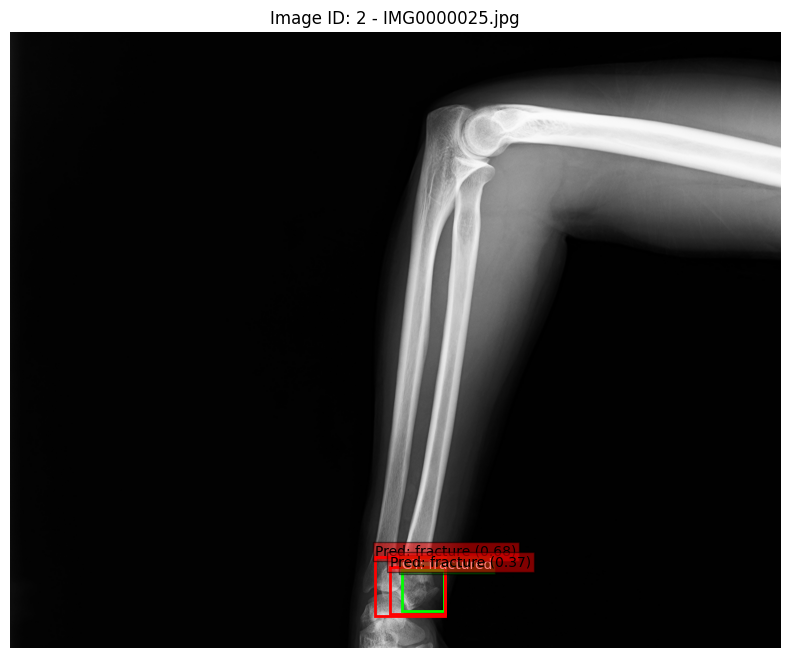


image 1/1 /content/FracAtlas/images/Fractured/IMG0000044.jpg: 640x512 (no detections), 29.7ms
Speed: 4.5ms preprocess, 29.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


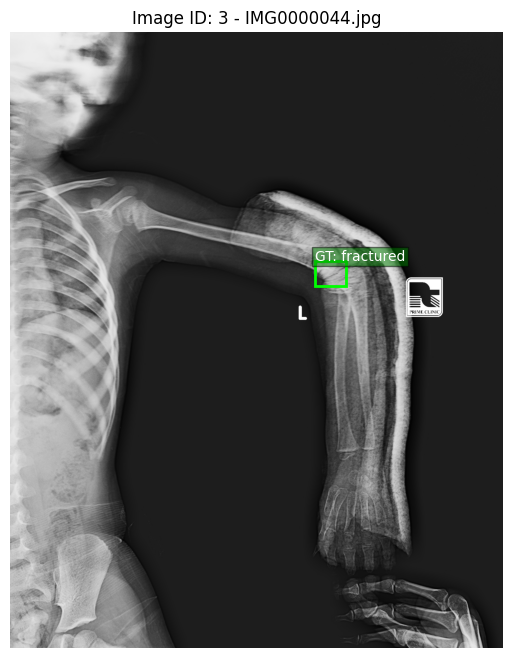


image 1/1 /content/FracAtlas/images/Fractured/IMG0000057.jpg: 640x512 2 fractures, 28.2ms
Speed: 3.1ms preprocess, 28.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)


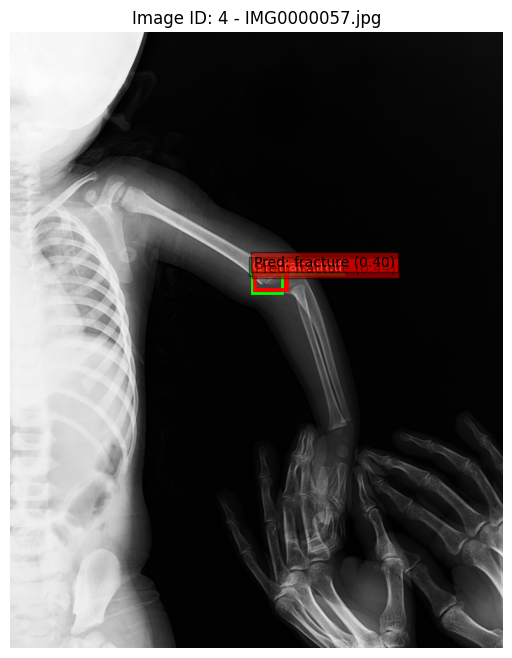


image 1/1 /content/FracAtlas/images/Fractured/IMG0000058.jpg: 640x512 1 fracture, 28.2ms
Speed: 3.2ms preprocess, 28.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)


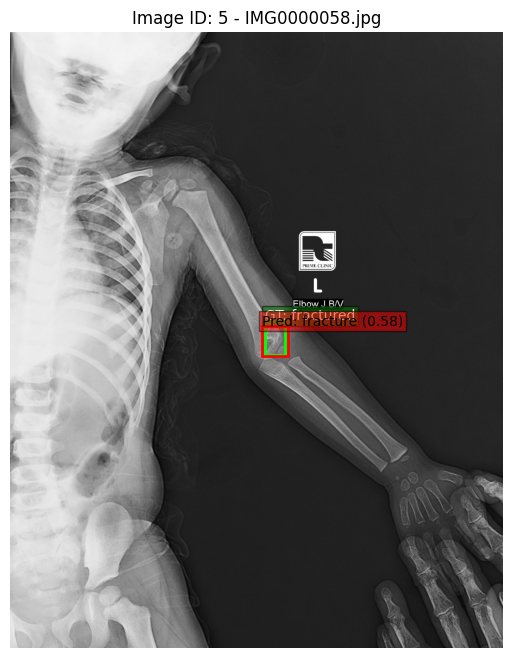


image 1/1 /content/FracAtlas/images/Fractured/IMG0000059.jpg: 640x512 1 fracture, 28.2ms
Speed: 3.1ms preprocess, 28.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)


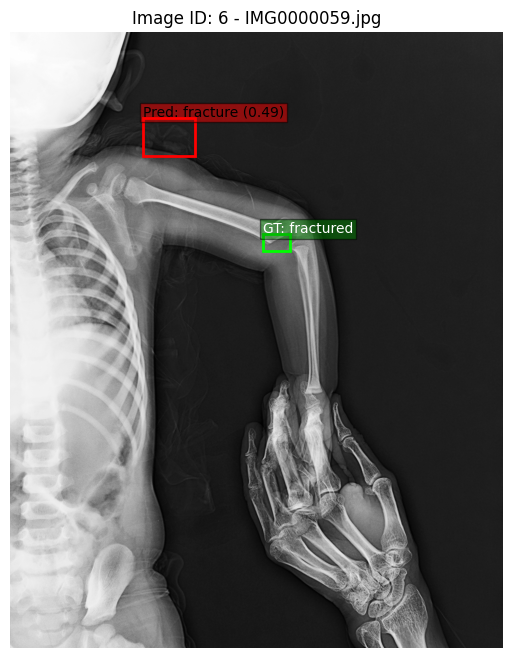


image 1/1 /content/FracAtlas/images/Fractured/IMG0000092.jpg: 640x512 (no detections), 28.2ms
Speed: 3.3ms preprocess, 28.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


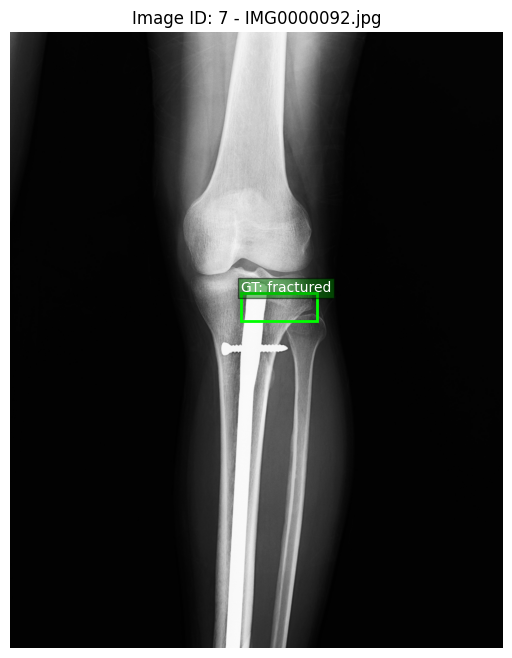


image 1/1 /content/FracAtlas/images/Fractured/IMG0000100.jpg: 640x512 1 fracture, 28.2ms
Speed: 3.2ms preprocess, 28.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)


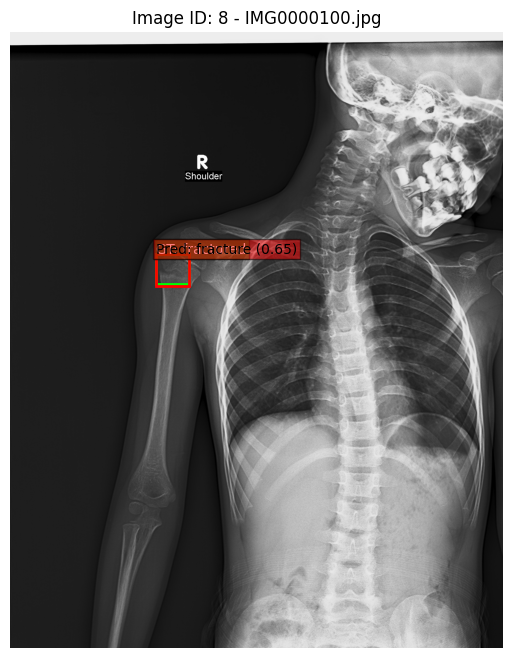


image 1/1 /content/FracAtlas/images/Fractured/IMG0000142.jpg: 640x512 1 fracture, 28.3ms
Speed: 3.2ms preprocess, 28.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)


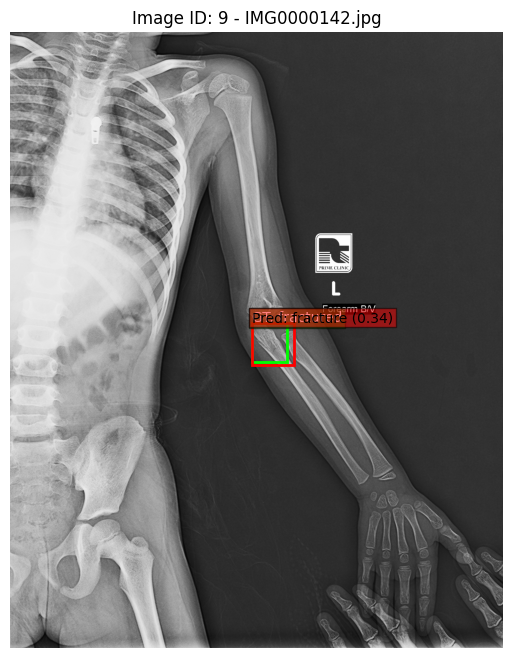

In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from ultralytics import YOLO

# ---------------------------------------------------------------------
# 1. Set Paths
# ---------------------------------------------------------------------
file_path = "/content/FracAtlas/Annotations/COCO JSON/COCO_fracture_masks.json"
images_folder = "/content/FracAtlas/images/Fractured"
model_path = "/content/drive/MyDrive/yolov8m_50e_best.pt"

# ---------------------------------------------------------------------
# 2. Load COCO Data
# ---------------------------------------------------------------------
with open(file_path, "r") as file:
    coco_data = json.load(file)

images_df = pd.DataFrame(coco_data.get("images", []))
annotations_df = pd.DataFrame(coco_data.get("annotations", []))
categories_df = pd.DataFrame(coco_data.get("categories", []))

cat_id_to_name = dict(zip(categories_df["id"], categories_df["name"]))

# Load the trained YOLO model
model = YOLO(model_path)

# ---------------------------------------------------------------------
# 3. Function: Show Ground Truth and Predictions
# ---------------------------------------------------------------------
def show_annotated_images_with_predictions(
    images_df, annotations_df, cat_id_to_name, images_folder, model, num_images=9
):
    for idx in range(min(num_images, len(images_df))):
        image_row = images_df.iloc[idx]
        img_id = image_row["id"]
        filename = image_row["file_name"]
        img_path = os.path.join(images_folder, filename)

        # Load image
        image = cv2.imread(img_path)
        if image is None:
            print(f"Warning: Could not load image: {img_path}")
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Get ground truth annotations
        image_annotations = annotations_df[annotations_df["image_id"] == img_id]

        # Get predictions from the model
        results = model(img_path, conf=0.3)
        predictions = results[0].boxes  # Get the Boxes object

        # Plot the image
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.imshow(image)

        # Overlay ground truth annotations (lime boxes)
        for _, ann_row in image_annotations.iterrows():
            x, y, w, h = ann_row["bbox"]
            rect = patches.Rectangle(
                (x, y), w, h, linewidth=2, edgecolor='lime', facecolor='none'
            )
            ax.add_patch(rect)

            cat_id = ann_row["category_id"]
            cat_name = cat_id_to_name.get(cat_id, str(cat_id))
            ax.text(
                x, y - 5,
                f"GT: {cat_name}",
                fontsize=10, color='white',
                bbox=dict(facecolor='green', alpha=0.5, pad=2)
            )

        # Overlay predictions (red boxes)
        if predictions is not None and len(predictions) > 0:
            for pred in predictions:
                x1, y1, x2, y2 = pred.xyxy[0].cpu().numpy()  # Bounding box coordinates
                conf = pred.conf[0].cpu().item()            # Confidence score
                cls = pred.cls[0].cpu().item()              # Class ID
                rect = patches.Rectangle(
                    (x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='red', facecolor='none'
                )
                ax.add_patch(rect)
                class_name = model.names[int(cls)]
                ax.text(
                    x1, y1 - 5,
                    f"Pred: {class_name} ({conf:.2f})",
                    fontsize=10, color='black',
                    bbox=dict(facecolor='red', alpha=0.5, pad=2)
                )

        # Set plot title and hide axis
        ax.set_title(f"Image ID: {img_id} - {filename}")
        plt.axis('off')
        plt.show()

# ---------------------------------------------------------------------
# 4. Run the Function
# ---------------------------------------------------------------------
show_annotated_images_with_predictions(
    images_df, annotations_df, cat_id_to_name, images_folder, model, num_images=9
)


## 🧠 ProtoViT Architecture for Classification

We define a custom neural network that:
- Uses a pretrained Vision Transformer (ViT) as a feature extractor.
- Projects image features to a learned set of **prototypes**.
- Uses a classification head to output binary predictions (fracture / no-fracture).


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Epoch 1, Loss: 1.2089
Epoch 2, Loss: 0.6486
Epoch 3, Loss: 0.6511
Epoch 4, Loss: 0.6498
Epoch 5, Loss: 0.6505
Epoch 6, Loss: 0.6482
Epoch 7, Loss: 0.6479
Epoch 8, Loss: 0.6445
Epoch 9, Loss: 0.6472
Epoch 10, Loss: 0.6419
Epoch 11, Loss: 0.6447
Epoch 12, Loss: 0.6432
Epoch 13, Loss: 0.6422
Epoch 14, Loss: 0.6419
Epoch 15, Loss: 0.6406
Epoch 16, Loss: 0.6378
Epoch 17, Loss: 0.6359
Epoch 18, Loss: 0.6330
Epoch 19, Loss: 0.6356
Epoch 20, Loss: 0.6338
Epoch 21, Loss: 0.6314
Epoch 22, Loss: 0.6313
Epoch 23, Loss: 0.6320
Epoch 24, Loss: 0.6298
Epoch 25, Loss: 0.6295
Epoch 26, Loss: 0.6290
Epoch 27, Loss: 0.6242
Epoch 28, Loss: 0.6242
Epoch 29, Loss: 0.6249
Epoch 30, Loss: 0.6233


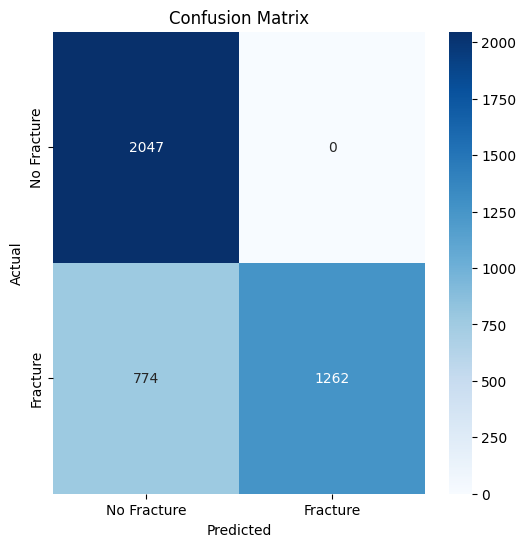

              precision    recall  f1-score   support

 No Fracture       0.73      1.00      0.84      2047
    Fracture       1.00      0.62      0.77      2036

    accuracy                           0.81      4083
   macro avg       0.86      0.81      0.80      4083
weighted avg       0.86      0.81      0.80      4083



FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/proto_vit_script.py'

In [ ]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import json
import os
import numpy as np
import cv2
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from timm import create_model
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, ConcatDataset
from einops import rearrange
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torch.nn.functional as F
from collections import Counter


class XRayCOCODataset(Dataset):
    def __init__(self, json_path, img_folder, transform=None):
        with open(json_path, 'r') as f:
            self.coco_data = json.load(f)
        self.img_folder = img_folder
        self.transform = transform
        self.images = {img['id']: img['file_name'] for img in self.coco_data['images']}
        # Group all annotations for each image.
        self.annotations = {}
        if "annotations" in self.coco_data:
            for ann in self.coco_data['annotations']:
                img_id = ann['image_id']
                if img_id in self.annotations:
                    self.annotations[img_id].append(ann)
                else:
                    self.annotations[img_id] = [ann]

    def create_mask(self, annotations, image_shape):
        mask = np.zeros(image_shape, dtype=np.uint8)
        for ann in annotations:
            for seg in ann['segmentation']:
                seg_np = np.array(seg).reshape((-1, 2)).astype(np.int32)
                cv2.fillPoly(mask, [seg_np], color=1)
        return torch.tensor(mask, dtype=torch.float32)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Use the JSON-provided fractured images.
        img_id = list(self.images.keys())[idx]
        img_path = os.path.join(self.img_folder, self.images[img_id])
        image = Image.open(img_path).convert("RGB")
        image_shape = (image.height, image.width)
        # If an annotation exists, label as fractured (1); else label 0.
        if img_id in self.annotations:
            mask = self.create_mask(self.annotations[img_id], image_shape)
            label = 1
        else:
            mask = torch.zeros(image_shape, dtype=torch.float32)
            label = 0

        if self.transform:
            image = self.transform(image)
            mask = mask.unsqueeze(0).unsqueeze(0)
            mask = F.interpolate(mask, size=(224, 224), mode='nearest')
            mask = mask.squeeze(0).squeeze(0)

        return image, mask, label

# ------------------------
# 2. Non-Fractured Dataset from Directory
# ------------------------

class NonFracturedDataset(Dataset):
    def __init__(self, img_folder, transform=None):
        self.img_folder = img_folder
        self.transform = transform
        self.image_files = [fname for fname in os.listdir(img_folder)
                            if fname.lower().endswith(('.jpg','.jpeg','.png'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_file = self.image_files[idx]
        img_path = os.path.join(self.img_folder, img_file)
        image = Image.open(img_path).convert("RGB")
        image_shape = (image.height, image.width)
        label = 0  # Non-fractured.
        mask = torch.zeros(image_shape, dtype=torch.float32)
        if self.transform:
            image = self.transform(image)
            mask = mask.unsqueeze(0).unsqueeze(0)
            mask = F.interpolate(mask, size=(224, 224), mode='nearest')
            mask = mask.squeeze(0).squeeze(0)
        return image, mask, label

# ------------------------
# 3. Pretrained Vision Transformer Backbone using forward_features
# ------------------------

class MAEPretrainedViT(nn.Module):
    def __init__(self):
        super().__init__()
        self.vit = create_model('vit_small_patch16_224', pretrained=True)
        self.vit.head = nn.Identity()  # Remove classification head.
    def forward(self, x):
        return self.vit.forward_features(x)

# ------------------------
# 4. Prototype-based ViT for Fracture Classification
# ------------------------

class ProtoViT(nn.Module):
    def __init__(self, vit_backbone, num_prototypes=20):
        super().__init__()
        self.backbone = vit_backbone
        self.prototype_layer = nn.Parameter(torch.randn(num_prototypes, 384))
        self.fc = nn.Linear(num_prototypes, 2)

    def extract_prototype_patches(self, feature_map, mask):
        mask = mask.unsqueeze(1)  # (B, 1, H, W)
        masked_features = feature_map * mask
        proto_feat = masked_features.mean(dim=[2, 3])  # (B, C)
        return proto_feat

    def forward(self, x, mask):
        features = self.backbone(x)  # Expected shape: (B, 1+196, 384)
        patch_tokens = features[:, 1:, :]  # Exclude CLS token; shape: (B, 196, 384)
        patch_features = rearrange(patch_tokens, 'b (h w) c -> b c h w', h=14, w=14)
        mask_resized = F.interpolate(mask.unsqueeze(1), size=(patch_features.shape[2], patch_features.shape[3]), mode='nearest').squeeze(1)
        proto_features = self.extract_prototype_patches(patch_features, mask_resized)  # (B, 384)
        proto_dist = torch.cdist(proto_features, self.prototype_layer)  # (B, num_prototypes)
        proto_scores = -proto_dist  # Convert distances to similarity scores.
        out = self.fc(proto_scores)  # (B, 2)
        return out, proto_scores

# ------------------------
# 5. Training and Evaluation Functions
# ------------------------

def train_model(model, dataloader, optimizer, criterion, device, num_epochs=30):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for images, masks, labels in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs, _ = model(images, masks)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}")

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, masks, labels in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            outputs, _ = model(images, masks)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Fracture', 'Fracture'],
                yticklabels=['No Fracture', 'Fracture'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(all_labels, all_preds, labels=[0,1], target_names=['No Fracture', 'Fracture']))

# ------------------------
# 6. Main Execution
# ------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transforms with data augmentation.
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load fractured dataset (using COCO JSON).
fractured_dataset = XRayCOCODataset(
    json_path="/content/FracAtlas/Annotations/COCO JSON/COCO_fracture_masks.json",
    img_folder="/content/FracAtlas/images/Fractured",
    transform=transform
)

# Load non-fractured dataset from a separate directory.
non_fractured_dataset = NonFracturedDataset(
    img_folder="/content/FracAtlas/images/Non_fractured",
    transform=transform
)

# Combine the two datasets.
combined_dataset = ConcatDataset([fractured_dataset, non_fractured_dataset])

# Compute label distribution for the weighted sampler.
all_labels = [label for _, _, label in combined_dataset]
label_counts = Counter(all_labels)
weights = [1.0 / label_counts[label] for label in all_labels]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# Create DataLoader.
dataloader = DataLoader(combined_dataset, batch_size=16, sampler=sampler)

# Initialize models.
mae_vit = MAEPretrainedViT().to(device)
proto_vit = ProtoViT(mae_vit, num_prototypes=10).to(device)

optimizer = optim.Adam(proto_vit.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Train and Evaluate.
train_model(proto_vit, dataloader, optimizer, criterion, device, num_epochs=30)
evaluate_model(proto_vit, dataloader, device)


with open("/mnt/data/proto_vit_script.py", "w") as file:
    file.write(code)

print("Code saved to /mnt/data/proto_vit_script.py")


In [ ]:
torch.save(proto_vit.state_dict(), "/content/drive/MyDrive/proto_vit_model.pth")


## 🔍 Interpretability: Visualizing Prototype Activations

We visualize the most activated prototypes per image to understand which features are being used for decision-making.

This enhances model transparency and helps confirm clinical relevance.


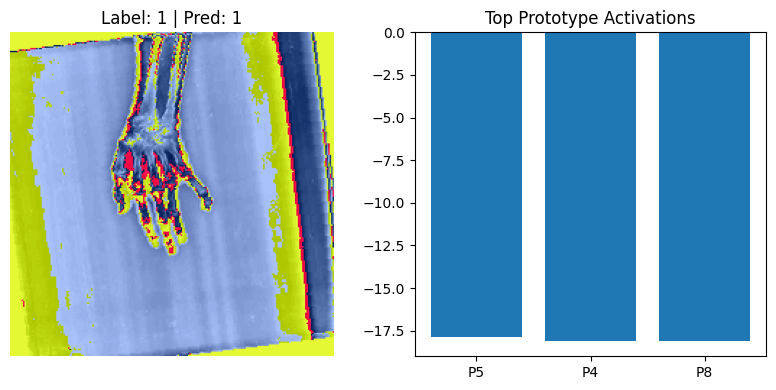

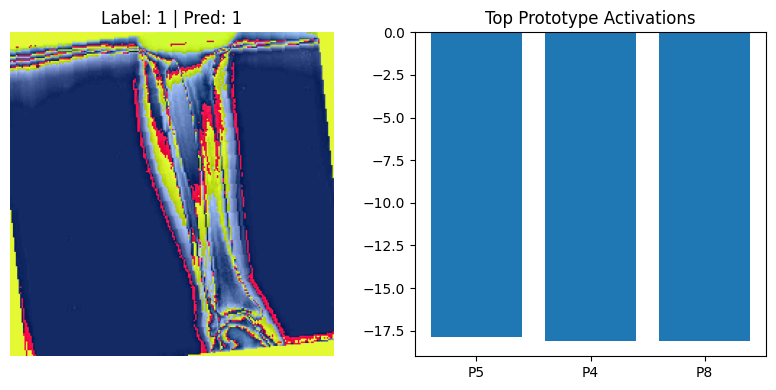

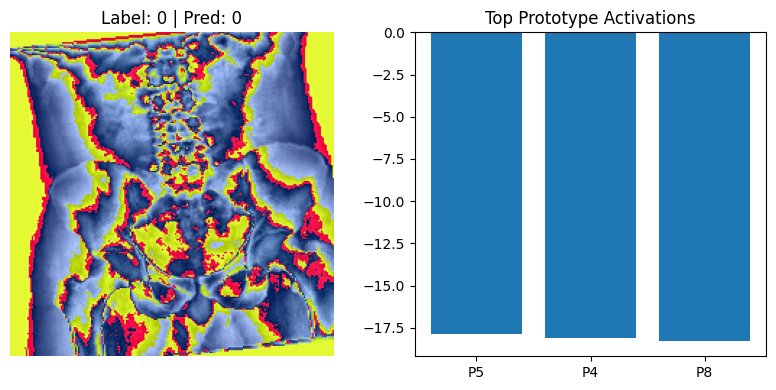

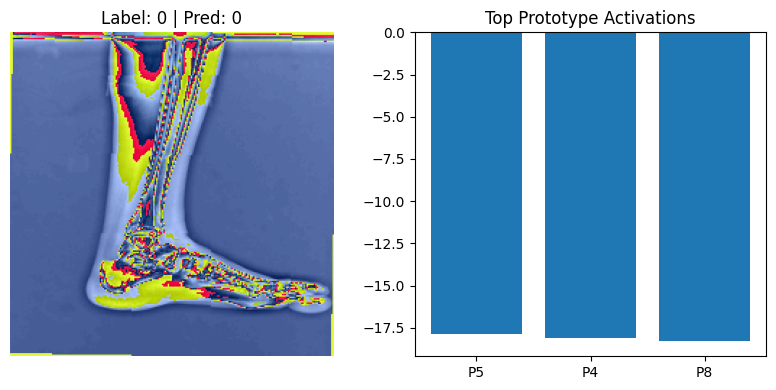

In [ ]:
# ==============================
# INTERPRETABILITY CELL
# ==============================
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.transforms.functional import to_pil_image

def interpretability_analysis(model, dataloader, device, num_images=4, top_k=3):
    """
    1. Takes a small batch from the dataloader.
    2. Extracts 'proto_scores' for each image.
    3. Displays the image alongside a bar chart of the top prototype activations.
    """

    model.eval()

    # Grab one batch of data
    images, masks, labels = next(iter(dataloader))
    images, masks, labels = images.to(device), masks.to(device), labels.to(device)

    # Forward pass to get predictions & prototype scores
    with torch.no_grad():
        outputs, proto_scores = model(images, masks)
        preds = outputs.argmax(dim=1)

    # Move arrays to CPU for plotting
    images = images.cpu()
    labels = labels.cpu().numpy()
    preds = preds.cpu().numpy()
    proto_scores = proto_scores.cpu().numpy()  # shape: (batch_size, num_prototypes)

    # We'll visualize only the first `num_images` in the batch
    num_images = min(num_images, len(images))

    # Create separate plots for each image
    for i in range(num_images):
        # Display the original image
        plt.figure(figsize=(8, 4))

        # 1) Show the X-ray in the left subplot
        plt.subplot(1, 2, 1)
        # Convert tensor to a PIL image for display
        pil_img = to_pil_image(images[i])
        plt.imshow(pil_img)
        title_text = f"Label: {labels[i]} | Pred: {preds[i]}"
        plt.title(title_text)
        plt.axis('off')

        # 2) Show top prototype scores in the right subplot
        plt.subplot(1, 2, 2)
        # Sort prototypes by descending activation (proto_scores are *higher* when closer)
        sorted_proto_ids = np.argsort(-proto_scores[i])
        top_proto_ids = sorted_proto_ids[:top_k]
        top_proto_values = proto_scores[i][top_proto_ids]

        plt.bar(range(top_k), top_proto_values)
        plt.xticks(range(top_k), [f"P{pid}" for pid in top_proto_ids])
        plt.title("Top Prototype Activations")

        plt.tight_layout()
        plt.show()


# -- Example Usage (AFTER TRAINING) --
interpretability_analysis(proto_vit, dataloader, device, num_images=4, top_k=3)


Image 1: Top prototypes used: ['P5', 'P4', 'P8']


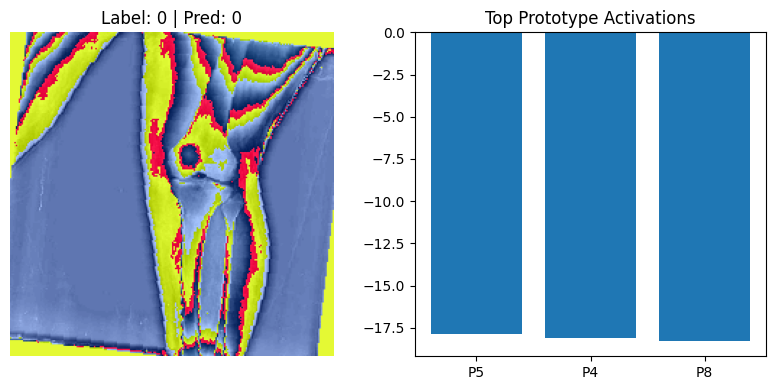

Image 2: Top prototypes used: ['P5', 'P4', 'P8']


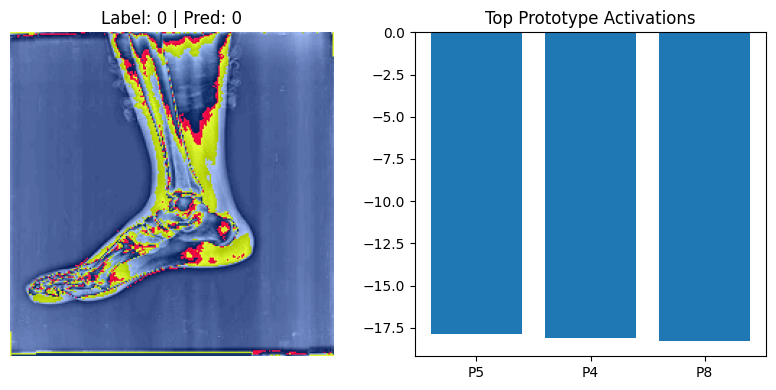

Image 3: Top prototypes used: ['P5', 'P4', 'P8']


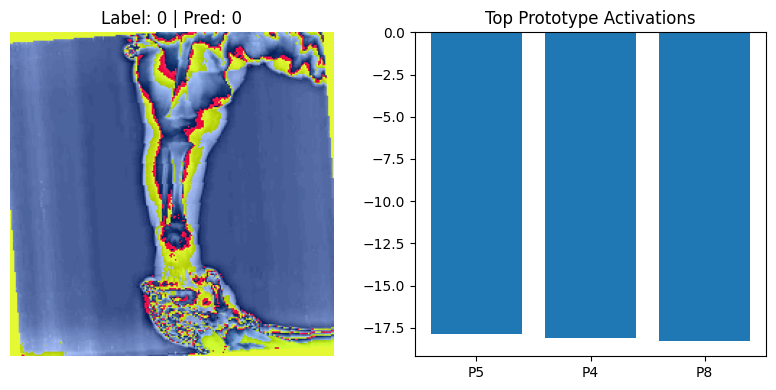

Image 4: Top prototypes used: ['P5', 'P4', 'P8']


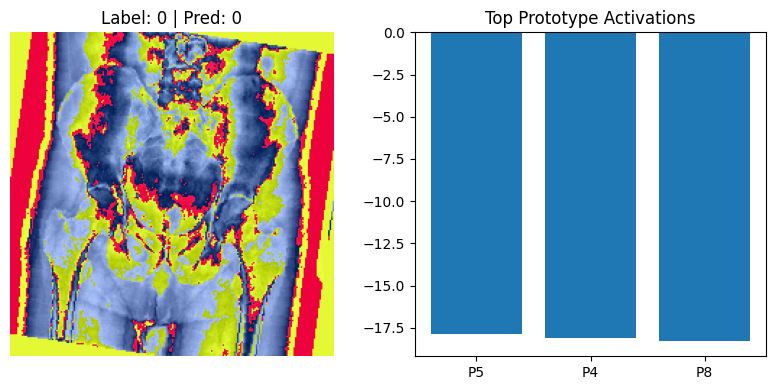

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.transforms.functional import to_pil_image

def interpretability_analysis(model, dataloader, device, num_images=4, top_k=3):
    """
    This function:
    1. Takes one batch from the dataloader.
    2. Extracts 'proto_scores' (similarity scores between image features and prototypes) for each image.
    3. Displays the image alongside a bar chart of the top prototype activations.
    4. Prints out the indices of the prototypes that were used.
    """
    model.eval()

    # Grab one batch of data
    images, masks, labels = next(iter(dataloader))
    images, masks, labels = images.to(device), masks.to(device), labels.to(device)

    # Forward pass to get predictions & prototype scores
    with torch.no_grad():
        outputs, proto_scores = model(images, masks)
        preds = outputs.argmax(dim=1)

    # Move arrays to CPU for plotting and analysis
    images = images.cpu()
    labels = labels.cpu().numpy()
    preds = preds.cpu().numpy()
    proto_scores = proto_scores.cpu().numpy()  # shape: (batch_size, num_prototypes)

    # We'll visualize only the first `num_images` in the batch
    num_images = min(num_images, len(images))

    # Process and display each image.
    for i in range(num_images):
        # Sort prototypes by descending activation.
        sorted_proto_ids = np.argsort(-proto_scores[i])
        top_proto_ids = sorted_proto_ids[:top_k]
        top_proto_values = proto_scores[i][top_proto_ids]

        # Print out which prototypes were used.
        print(f"Image {i+1}: Top prototypes used: {[f'P{pid}' for pid in top_proto_ids]}")

        # Create a figure with two subplots.
        plt.figure(figsize=(8, 4))

        # Left subplot: Display the original image with label and prediction.
        plt.subplot(1, 2, 1)
        pil_img = to_pil_image(images[i])
        plt.imshow(pil_img)
        title_text = f"Label: {labels[i]} | Pred: {preds[i]}"
        plt.title(title_text)
        plt.axis('off')

        # Right subplot: Display the bar chart of top prototype activations.
        plt.subplot(1, 2, 2)
        plt.bar(range(top_k), top_proto_values)
        plt.xticks(range(top_k), [f"P{pid}" for pid in top_proto_ids])
        plt.title("Top Prototype Activations")

        plt.tight_layout()
        plt.show()

# Example usage (after training):
interpretability_analysis(proto_vit, dataloader, device, num_images=4, top_k=3)


## 🧪 Inference & Image Filtering

We run ProtoViT inference on the entire dataset and:
- Identify images classified as fractured.
- Copy these to a new folder to be processed by the YOLO object detector.

This acts as a filter to avoid unnecessary detection on non-fractured X-rays.


In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
# Make sure to import your dataset and model definitions.
# from your_model_module import XRayCOCODataset, MAEPretrainedViT, ProtoViT

# Define the transform (same as used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Set paths for the COCO JSON file and image folder for inference.
inference_json = "/content/FracAtlas/Annotations/COCO JSON/COCO_fracture_masks.json"
inference_img_folder = "/content/FracAtlas/images/Fractured"  # Adjust if needed

# Create the inference dataset; this will generate masks from the COCO annotations.
inference_dataset = XRayCOCODataset(json_path=inference_json,
                                    img_folder=inference_img_folder,
                                    transform=transform)

# Create a DataLoader for inference.
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False)

# Set the device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load your trained model exactly as you provided.
mae_vit = MAEPretrainedViT().to(device)
model = ProtoViT(mae_vit, num_prototypes=10).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/proto_vit_model.pth"))
model.eval()

# Run inference using the dataset pipeline (images and their generated masks).
all_predictions = []
with torch.no_grad():
    for images, masks, labels in inference_loader:
        images = images.to(device)
        masks = masks.to(device)
        outputs, _ = model(images, masks)
        preds = torch.argmax(outputs, dim=1)
        all_predictions.extend(preds.cpu().numpy())

print("Inference predictions:", all_predictions)


Using device: cuda
Inference predictions: [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64

In [ ]:
import os
import json
import cv2
import shutil
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import numpy as np

# -------------
# Inference Dataset that returns file name
# -------------
class InferenceXRayCOCODataset(Dataset):
    def __init__(self, json_path, img_folder, transform=None):
        with open(json_path, 'r') as f:
            self.coco_data = json.load(f)
        self.img_folder = img_folder
        self.transform = transform
        # Map image IDs to filenames
        self.images = {img['id']: img['file_name'] for img in self.coco_data['images']}
        # Group all annotations per image ID
        self.annotations = {}
        if "annotations" in self.coco_data:
            for ann in self.coco_data['annotations']:
                img_id = ann['image_id']
                if img_id in self.annotations:
                    self.annotations[img_id].append(ann)
                else:
                    self.annotations[img_id] = [ann]

    def create_mask(self, annotations, image_shape):
        mask = np.zeros(image_shape, dtype=np.uint8)
        for ann in annotations:
            for seg in ann['segmentation']:
                seg_np = np.array(seg).reshape((-1, 2)).astype(np.int32)
                cv2.fillPoly(mask, [seg_np], color=1)
        return torch.tensor(mask, dtype=torch.float32)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get the image id and file name.
        img_ids = list(self.images.keys())
        img_id = img_ids[idx]
        file_name = self.images[img_id]
        img_path = os.path.join(self.img_folder, file_name)

        # Load image and get its original shape.
        image = Image.open(img_path).convert("RGB")
        image_shape = (image.height, image.width)

        # Generate mask from annotations if present; else, create a zero mask.
        if img_id in self.annotations:
            mask = self.create_mask(self.annotations[img_id], image_shape)
            label = 1  # Fracture
        else:
            mask = torch.zeros(image_shape, dtype=torch.float32)
            label = 0  # Non-fracture

        if self.transform:
            image = self.transform(image)
            mask = mask.unsqueeze(0).unsqueeze(0)
            mask = F.interpolate(mask, size=(224, 224), mode='nearest')
            mask = mask.squeeze(0).squeeze(0)

        return image, mask, label, file_name

# -------------
# Inference Setup
# -------------

# Define the transform (same as used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Set paths for the COCO JSON file and the inference image folder.
inference_json = "/content/FracAtlas/Annotations/COCO JSON/COCO_fracture_masks.json"
inference_img_folder = "/content/FracAtlas/images/Fractured"  # Adjust if needed

# Create the inference dataset; this generates masks from the COCO annotations.
inference_dataset = InferenceXRayCOCODataset(
    json_path=inference_json,
    img_folder=inference_img_folder,
    transform=transform
)

# Create a DataLoader for inference.
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False)

# Set the device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------
# Load your trained model (as before)
# -------------
# (Assuming your model definitions for MAEPretrainedViT and ProtoViT are already in your environment)
mae_vit = MAEPretrainedViT().to(device)
model = ProtoViT(mae_vit, num_prototypes=10).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/proto_vit_model.pth"))
model.eval()
print("ProtoViT model loaded successfully for inference.")

# -------------
# Run Inference & Copy Fracture Images
# -------------

# Folder to store images predicted as fracture for YOLO processing.
yolo_input_folder = "/content/drive/MyDrive/data/fracture_images_for_yolo"
if not os.path.exists(yolo_input_folder):
    os.makedirs(yolo_input_folder)
    print("Created YOLO input folder:", yolo_input_folder)
else:
    print("YOLO input folder exists:", yolo_input_folder)

all_predictions = []

with torch.no_grad():
    for images, masks, labels, file_names in inference_loader:
        images = images.to(device)
        masks = masks.to(device)
        outputs, _ = model(images, masks)
        preds = torch.argmax(outputs, dim=1)
        preds_np = preds.cpu().numpy()

        for i, pred in enumerate(preds_np):
            all_predictions.append(pred)
            # If classified as fracture (assuming label 1 = fracture), copy the image file.
            if pred == 1:
                file_name = file_names[i]
                src_path = os.path.join(inference_img_folder, file_name)
                dst_path = os.path.join(yolo_input_folder, file_name)
                try:
                    shutil.copy(src_path, dst_path)
                    print(f"Copied {file_name} to YOLO input folder.")
                except Exception as e:
                    print(f"Error copying {file_name}: {e}")

print("Inference predictions:", all_predictions)
print("All fracture images copied to:", yolo_input_folder)

# -------------
# Run YOLO Detection on the Fracture Images Folder
# -------------
model_path = "/content/drive/MyDrive/yolov8m_50e_best.pt"
# Here, the YOLO command is executed to detect objects on all images in the yolo_input_folder.
!yolo task=detect mode=predict model={model_path} source={yolo_input_folder}


Using device: cuda
ProtoViT model loaded successfully for inference.
Created YOLO input folder: /content/drive/MyDrive/data/fracture_images_for_yolo
Copied IMG0000019.jpg to YOLO input folder.
Copied IMG0000092.jpg to YOLO input folder.
Copied IMG0000142.jpg to YOLO input folder.
Copied IMG0000143.jpg to YOLO input folder.
Copied IMG0000151.jpg to YOLO input folder.
Copied IMG0000188.jpg to YOLO input folder.
Copied IMG0000190.jpg to YOLO input folder.
Copied IMG0000206.jpg to YOLO input folder.
Copied IMG0000207.jpg to YOLO input folder.
Copied IMG0000261.jpg to YOLO input folder.
Copied IMG0000284.jpg to YOLO input folder.
Copied IMG0000307.jpg to YOLO input folder.
Copied IMG0000351.jpg to YOLO input folder.
Copied IMG0000352.jpg to YOLO input folder.
Copied IMG0000443.jpg to YOLO input folder.
Copied IMG0000453.jpg to YOLO input folder.
Copied IMG0000454.jpg to YOLO input folder.
Copied IMG0000455.jpg to YOLO input folder.
Copied IMG0000456.jpg to YOLO input folder.
Copied IMG00004

In [ ]:
from ultralytics import YOLO

# Load your trained model
model = YOLO("/content/drive/MyDrive/runs/detect/yolov8m_50e/weights/best.pt")  # Update path if different

# Run evaluation (val dataset must be defined in your data.yaml)
metrics = model.val()  # returns a dictionary of metrics


Ultralytics 8.3.109 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /content/dataset/labels/val.cache... 144 images, 0 backgrounds, 0 corrupt: 100%|██████████| 144/144 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.52it/s]


                   all        144        173      0.753      0.509      0.586      0.241
Speed: 1.4ms preprocess, 21.4ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/val


## 🎯 Stage 2: Fracture Localization using YOLOv8

We use a pretrained YOLOv8 model, fine-tuned on fractured X-ray images, to detect the **exact location** of the fracture.

Predictions are run only on images that ProtoViT flagged as fractured.


In [ ]:
# Print summary of evaluation
print("mAP@0.5:", metrics.box.map50)
print("mAP@0.5:0.95:", metrics.box.map)




mAP@0.5: 0.5859275011009262
mAP@0.5:0.95: 0.24055224883590526


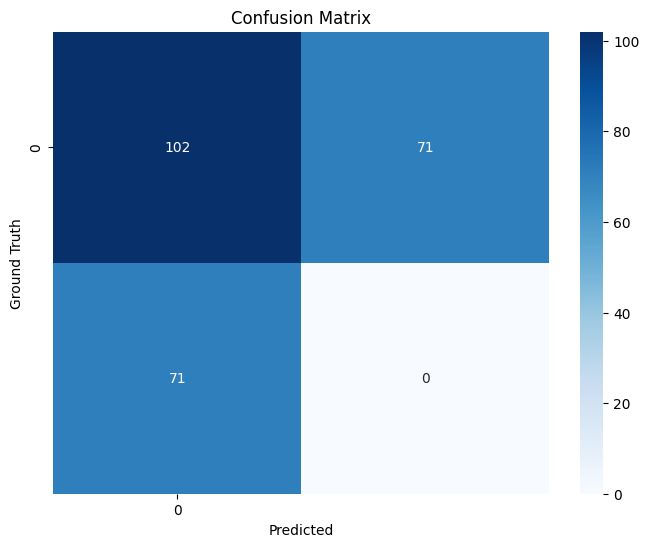

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Confusion matrix is part of results, extract it like this
conf_matrix = metrics.confusion_matrix.matrix  # shape [num_classes x num_classes]
class_names = model.names

# Plot it
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".0f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")
plt.show()
